# BERT

As second attempt, I'll train BERT to classify the reviews. I'll use the same dataset as before, but this time I'll use the `bert-base-uncased` model.

### Data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [4]:
os.getcwd()

'/content'

In [5]:
train = pd.read_csv('/content/drive/MyDrive/sentiment_analysis/train.csv')
train.head()

,id,text,rating
0,0,This was the first televised episode of the Co...,7
1,1,"Jim Carrey is good as usual, and even though t...",10
2,2,"I saw ""A Page of Madness"" in a silent film cou...",10
3,3,A very close and sharp discription of the bubb...,10
4,4,Terry Gilliam's and David Peoples' teamed up t...,10


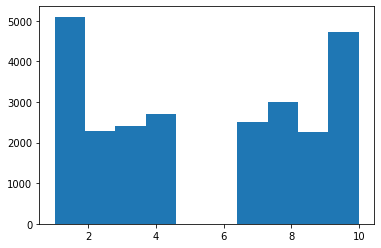

In [6]:
import matplotlib.pyplot as plt

plt.hist(train['rating'])
plt.show()

Dataset is missing ratings 5 and 6 completely, so model will be trained to classify into 8 classes

### TRAINING

In [8]:
from transformers import BertForSequenceClassification, BertTokenizer

In [9]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 8,
    output_attentions = False, 
    output_hidden_states = False 
)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [10]:
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
model = model.to(device)

In [12]:
ratings = train.rating.values

train.rating.value_counts()

1     5100
10    4732
8     3009
4     2696
7     2496
3     2420
2     2284
9     2263
Name: rating, dtype: int64

We got to encode ratings so their values are sequential, and we can use them as labels for the model.

In [13]:
ratings

array([ 7, 10, 10, ...,  4,  2,  2])

In [14]:
uni = train.rating.unique()
uni = np.sort(uni)
uni

array([ 1,  2,  3,  4,  7,  8,  9, 10])

In [15]:
map_uni = {val: idx for idx, val in enumerate(uni)}
map_uni

{1: 0, 2: 1, 3: 2, 4: 3, 7: 4, 8: 5, 9: 6, 10: 7}

#### Encoding

In [16]:
input_ids = []
attention_masks = []
reviews = train.text.values


for review in reviews:
    encoded_dict = tokenizer.encode_plus(
                        review,                     
                        add_special_tokens = True, 
                        truncation=True,
                        max_length = 512,
                        padding='max_length',         
                        return_attention_mask = True,  
                        return_tensors = 'pt',     
                   )
        
    input_ids.append(encoded_dict['input_ids'])   
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

In [17]:
ratings = [map_uni[rate] for rate in ratings]
labels = torch.tensor(ratings)

#### Datasets

In [18]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, random_split

In [19]:
dataset = TensorDataset(input_ids, attention_masks, labels, )

train_size = int(0.8 * len(dataset))
val_size = len(dataset)  - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

20,000 training samples
5,000 validation samples


In [20]:
batch_size = 8

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size,
            num_workers=2
        )

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), 
            batch_size = batch_size,
            num_workers=2
        )

dataloader = {'train': train_dataloader,
              'val': validation_dataloader}

#### Training loop

In [21]:
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm
import numpy as np
import time
import copy

In [25]:
epochs = 4

optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8 
                )

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)
  

In [26]:
def train_model(model, dataloaders, optimizer, 
                scheduler, num_epochs=25):
  
    since = time.perf_counter()

    val_acc_history = []
    val_loss_history = []

    lengths = {}
    for phase in ['train', 'val']:
        lengths[phase] = len(dataloaders[phase].dataset)
        print(f'{phase}_iters: {lengths[phase] // batch_size}')

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    min_loss = float('inf')

    for epoch in range(num_epochs):
        epoch_start = time.perf_counter()

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval() 

            lr = scheduler.optimizer.param_groups[0]['lr']
            running_loss = 0.0
            running_corrects = 0
            running_accuracy = 0.0

            with tqdm(dataloaders[phase], unit="batch", miniters=1) as tepoch:
                for iter, (input_ids, input_mask, labels) in enumerate(tepoch, start=1):
                    if phase == 'train':
                        tepoch.set_description(f"Epoch {epoch + 1}")
                    else:
                        tepoch.set_description(f"Validation {epoch + 1}")

                    input_ids = input_ids.to(device)
                    input_mask = input_mask.to(device)
                    labels = labels.to(device)
                    #labels = labels.type(torch.int64)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        output = model(input_ids, 
                                      token_type_ids=None, 
                                      attention_mask=input_mask,
                                      labels=labels,
                                      )

                        loss = output.loss

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * batch_size

                    logits = output.logits
                    log_soft = torch.softmax(logits, 1).detach().cpu()
                    weighted = []

                    for i, x in enumerate(log_soft.numpy()):
                        weighted.append([0])
                        for j, proba in enumerate(x):
                            weighted[i] += j * proba

                    labels_cpu = labels.detach().cpu().numpy()
                    MSE = sum(
                        1 / batch_size * (label - w_sum) ** 2
                        for w_sum, label in zip(weighted, labels_cpu)
                    )
                    _, preds = torch.max(torch.softmax(logits, 1), 1)

                    running_corrects += torch.sum(preds==labels.data)
                    running_accuracy = running_corrects / (iter * batch_size)
                    tepoch.set_postfix(loss=loss.item(), accuracy=running_accuracy.item(), MSE=MSE[0])

                epoch_loss = running_loss / lengths[phase]
                epoch_acc = running_corrects.double() / lengths[phase]

                print(f'{phase}_loss: {epoch_loss:.4f} {phase}_acc: {epoch_acc:.4f}')

                if phase == 'val':
                    if epoch_acc > best_acc:
                        best_acc = epoch_acc

                    if min_loss >= epoch_loss:
                        min_loss = epoch_loss
                        best_model_wts = copy.deepcopy(model.state_dict())
                        torch.save(model, '/content/drive/MyDrive/models/bert_trained.pt')

                    scheduler.step(epoch_loss)
                    val_acc_history.append(epoch_acc)
                    val_loss_history.append(epoch_loss)
                    print(f"lr: {lr:.0E}  min_loss: {min_loss:.4f}")

        epoch_end = time.perf_counter()
        time_elapsed =  epoch_end - epoch_start

        print(f'Epoch {epoch + 1} took {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print()

    time_elapsed = time.perf_counter() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val_acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_loss_history

We will train model for 4 epochs as Hugging Face suggests.

In [27]:
model_trained, acc_hist, loss_hist = train_model(model, dataloader, optimizer, scheduler,
                                                num_epochs=epochs)

train_iters: 2500
val_iters: 625


Epoch 1: 100%|██████████| 2500/2500 [35:06<00:00,  1.19batch/s, MSE=1.19, accuracy=0.426, loss=1.01]


train_loss: 1.4485 train_acc: 0.4261


Validation 1: 100%|██████████| 625/625 [03:03<00:00,  3.40batch/s, MSE=0.769, accuracy=0.47, loss=1.37]


val_loss: 1.3133 val_acc: 0.4700


/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


lr: 2E-05  min_loss: 1.3133
Epoch 1 took 38m 16s



Epoch 2: 100%|██████████| 2500/2500 [35:02<00:00,  1.19batch/s, MSE=0.505, accuracy=0.537, loss=0.889]


train_loss: 1.1601 train_acc: 0.5368


Validation 2: 100%|██████████| 625/625 [03:03<00:00,  3.40batch/s, MSE=0.885, accuracy=0.518, loss=1.34]


val_loss: 1.2211 val_acc: 0.5178
lr: 2E-05  min_loss: 1.2211
Epoch 2 took 38m 8s



Epoch 3: 100%|██████████| 2500/2500 [35:02<00:00,  1.19batch/s, MSE=0.534, accuracy=0.615, loss=0.9]


train_loss: 0.9512 train_acc: 0.6155


Validation 3: 100%|██████████| 625/625 [03:03<00:00,  3.40batch/s, MSE=0.922, accuracy=0.495, loss=1.43]


val_loss: 1.2924 val_acc: 0.4946
lr: 2E-05  min_loss: 1.2211
Epoch 3 took 38m 7s



Epoch 4: 100%|██████████| 2500/2500 [35:04<00:00,  1.19batch/s, MSE=0.856, accuracy=0.692, loss=1.34]


train_loss: 0.7670 train_acc: 0.6922


Validation 4: 100%|██████████| 625/625 [03:03<00:00,  3.40batch/s, MSE=0.968, accuracy=0.471, loss=1.72]

val_loss: 1.4376 val_acc: 0.4708
lr: 2E-05  min_loss: 1.2211
Epoch 4 took 38m 9s

Training complete in 152m 41s
Best val_acc: 0.517800


Two epochs were enough to get 52% accuracy on validation set.